In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.model import fit
from fastai.dataset import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import random

In [2]:
bs,bptt = 64,70

## Language modeling

### Data

In [3]:
import os, requests, time
# feedparser isn't a fastai dependency so you may need to install it.
import feedparser
import pandas as pd


class GetArXiv(object):
    def __init__(self, pickle_path, categories=list()):
        """
        :param pickle_path (str): path to pickle data file to save/load
        :param pickle_name (str): file name to save pickle to path
        :param categories (list): arXiv categories to query
        """
        if os.path.isdir(pickle_path):
            pickle_path = f"{pickle_path}{'' if pickle_path[-1] == '/' else '/'}all_arxiv.pkl"
        if len(categories) < 1:
            categories = ['cs*', 'cond-mat.dis-nn', 'q-bio.NC', 'stat.CO', 'stat.ML']
        # categories += ['cs.CV', 'cs.AI', 'cs.LG', 'cs.CL']

        self.categories = categories
        self.pickle_path = pickle_path
        self.base_url = 'http://export.arxiv.org/api/query'

    @staticmethod
    def build_qs(categories):
        """Build query string from categories"""
        return '+OR+'.join(['cat:'+c for c in categories])

    @staticmethod
    def get_entry_dict(entry):
        """Return a dictionary with the items we want from a feedparser entry"""
        try:
            return dict(title=entry['title'], authors=[a['name'] for a in entry['authors']],
                        published=pd.Timestamp(entry['published']), summary=entry['summary'],
                        link=entry['link'], category=entry['category'])
        except KeyError:
            print('Missing keys in row: {}'.format(entry))
            return None

    @staticmethod
    def strip_version(link):
        """Strip version number from arXiv paper link"""
        return link[:-2]

    def fetch_updated_data(self, max_retry=5, pg_offset=0, pg_size=1000, wait_time=15):
        """
        Get new papers from arXiv server
        :param max_retry: max number of time to retry request
        :param pg_offset: number of pages to offset
        :param pg_size: num abstracts to fetch per request
        :param wait_time: num seconds to wait between requests
        """
        i, retry = pg_offset, 0
        df = pd.DataFrame()
        past_links = []
        if os.path.isfile(self.pickle_path):
            df = pd.read_pickle(self.pickle_path)
            df.reset_index()
        if len(df) > 0: past_links = df.link.apply(self.strip_version)

        while True:
            params = dict(search_query=self.build_qs(self.categories),
                          sortBy='submittedDate', start=pg_size*i, max_results=pg_size)
            response = requests.get(self.base_url, params='&'.join([f'{k}={v}' for k, v in params.items()]))
            entries = feedparser.parse(response.text).entries
            if len(entries) < 1:
                if retry < max_retry:
                    retry += 1
                    time.sleep(wait_time)
                    continue
                break

            results_df = pd.DataFrame([self.get_entry_dict(e) for e in entries])
            max_date = results_df.published.max().date()
            new_links = ~results_df.link.apply(self.strip_version).isin(past_links)
            print(f'{i}. Fetched {len(results_df)} abstracts published {max_date} and earlier')
            if not new_links.any():
                break

            df = pd.concat((df, results_df.loc[new_links]), ignore_index=True)
            i += 1
            retry = 0
            time.sleep(wait_time)

        print(f'Downloaded {len(df)-len(past_links)} new abstracts')
        df.sort_values('published', ascending=False).groupby('link').first().reset_index()
        df.to_pickle(self.pickle_path)
        return df

    @classmethod
    def load(cls, pickle_path):
        """Load data from pickle and remove duplicates"""
        return pd.read_pickle(cls(pickle_path).pickle_path)

    @classmethod
    def update(cls, pickle_path, categories=list(), **kwargs):
        """
        Update arXiv data pickle with the latest abstracts
        """
        cls(pickle_path, categories).fetch_updated_data(**kwargs)
        return True

In [4]:
PATH='data/arxiv/'

ALL_ARXIV = f'{PATH}all_arxiv.pkl'

# all_arxiv.pkl: if arxiv hasn't been downloaded yet, it'll take some time to get it - go get some coffee
if not os.path.exists(ALL_ARXIV): GetArXiv.update(ALL_ARXIV)

# arxiv.csv: see dl1/nlp-arxiv.ipynb to get this one
df_mb = pd.read_csv(f'{PATH}arxiv.csv')
df_all = pd.read_pickle(ALL_ARXIV)

In [5]:
df_mb.iloc[0]

link                                  arxiv.org/abs/1611.10003
time                                                       NaN
favorites                                                  NaN
rts                                                        NaN
authors                      [Tom A. F. Anderson, C. -H. Ruan]
category                                              q-bio.NC
published                                  2016-11-30 05:17:11
summary      In summary of the research findings presented ...
title        Vocabulary and the Brain: Evidence from Neuroi...
tweeted                                                      0
Name: 0, dtype: object

In [6]:
df_all.iloc[0]

authors                 [Srishti Dhamija, Pradeep Varakantham]
category                                                 cs.SY
link                         http://arxiv.org/abs/1812.05591v1
published                            2018-12-13 18:57:53+00:00
summary      Real-time traffic signal control systems can e...
title        TuSeRACT: Turn-Sample-Based Real-Time Traffic ...
Name: 0, dtype: object

In [7]:
def get_txt(df):
    return '<CAT> ' + df.category.str.replace(r'[\.\-]','') + ' <SUMM> ' + df.summary + ' <TITLE> ' + df.title
df_mb['txt'] = get_txt(df_mb)
df_all['txt'] = get_txt(df_all)
n=len(df_all); n

50000

In [8]:
df_all.iloc[0]['txt']

'<CAT> csSY <SUMM> Real-time traffic signal control systems can effectively reduce urban traffic\ncongestion but can also become significant contributors to congestion if poorly\ntimed. Real-time traffic signal control is typically challenging owing to\nconstantly changing traffic demand patterns, very limited planning time and\nvarious sources of uncertainty in the real world (due to vehicle detection or\nunobserved vehicle turn movements, for instance). SURTRAC (Scalable URban\nTRAffic Control) is a recently developed traffic signal control approach which\ncomputes delay-minimising and coordinated (across neighbouring traffic lights)\nschedules of oncoming vehicle clusters in real time. To ensure real-time\nresponsiveness in the presence of turn-induced uncertainty, SURTRAC computes\nschedules which minimize the delay for the expected turn movements as opposed\nto minimizing the expected delay under turn-induced uncertainty. Furthermore,\nexpected outgoing traffic clusters are commun

In [9]:
os.makedirs(f'{PATH}trn/yes', exist_ok=True)
os.makedirs(f'{PATH}val/yes', exist_ok=True)
os.makedirs(f'{PATH}trn/no', exist_ok=True)
os.makedirs(f'{PATH}val/no', exist_ok=True)
os.makedirs(f'{PATH}all/trn', exist_ok=True)
os.makedirs(f'{PATH}all/val', exist_ok=True)
os.makedirs(f'{PATH}models', exist_ok=True)

In [10]:
#for (i,(_,r)) in enumerate(df_all.iterrows()):
#    dset = 'trn' if random.random()>0.1 else 'val'
#    open(f'{PATH}all/{dset}/{i}.txt', 'w').write(r['txt'])

In [11]:
#for (i,(_,r)) in enumerate(df_mb.iterrows()):
#    lbl = 'yes' if r.tweeted else 'no'
#    dset = 'trn' if random.random()>0.1 else 'val'
#    open(f'{PATH}{dset}/{lbl}/{i}.txt', 'w').write(r['txt'])

In [12]:
from spacy.symbols import ORTH

# install the 'en' model if the next line of code fails by running:
#python -m spacy download en              # default English model (~50MB)
#python -m spacy download en_core_web_md  # larger English model (~1GB)
my_tok = spacy.load('en')

my_tok.tokenizer.add_special_case('<SUMM>', [{ORTH: '<SUMM>'}])
my_tok.tokenizer.add_special_case('<CAT>', [{ORTH: '<CAT>'}])
my_tok.tokenizer.add_special_case('<TITLE>', [{ORTH: '<TITLE>'}])
my_tok.tokenizer.add_special_case('<BR />', [{ORTH: '<BR />'}])
my_tok.tokenizer.add_special_case('<BR>', [{ORTH: '<BR>'}])

def my_spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(x)]

In [13]:
TEXT = data.Field(lower=True, tokenize=my_spacy_tok)
FILES = dict(train='trn', validation='val', test='val')
md = LanguageModelData.from_text_files(f'{PATH}all/', TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [18]:
len(md.trn_ds[0].text)

10139433

In [67]:
it = iter(md.trn_dl)

In [68]:
elt = next(it)

In [69]:
print(elt[0].shape)
print(elt[0].shape[0] * elt[0].shape[1])
print(elt[1].shape)

torch.Size([66, 64])
4224
torch.Size([4224])


In [70]:
elt

(tensor([[  23,  599, 2932,  ..., 7639,    6,    6],
         [ 907,    3,   15,  ...,   66, 2127,  803],
         [  25,   33,    2,  ..., 9603,   21,  264],
         ...,
         [   4,  533,    9,  ...,   35,    2, 3512],
         [ 971,    7, 4125,  ..., 8676, 1021,  146],
         [   5,  323,    8,  ...,    4,   14,    3]]),
 tensor([ 907,    3,   15,  ...,   11, 1218,   97]))

In [71]:
elt[1][(elt[0].shape[0] - 1) * 64 - 2:]

tensor([   14,     3,    57,    22,  1459,     7,     2,   636,   151,    38,
         2415,   356,    60,   190, 18368,   342,   196,  1215,   934,   196,
          120,    30,    85,    21,     3,     0,     6,     3,     0,    40,
         1547,  2169,   519,     3,    12,   422,   432,    11,   198,    17,
          417,   564,    62,     5,     9,    54,     6,    57,   985,    11,
         1312,    13,     2,  1533,    20,    27,  7740,     2,  3409,  3889,
           29,     2,    26,    11,  1218,    97])

In [72]:
elt_next = next(it)

In [73]:
elt_next

(tensor([[  57,   22, 1459,  ...,   11, 1218,   97],
         [   0, 3312,    6,  ...,   46,    7,   36],
         [  40,    5,  498,  ...,    2, 3139,    8],
         ...,
         [   7,    4,  891,  ...,   10,  344,  147],
         [1006, 7124,    2,  ...,  244, 3652,   52],
         [   5,   40,  131,  ..., 8671,   54,   97]]),
 tensor([   0, 3312,    6,  ...,   13, 1920,    2]))

In [77]:
print(elt_next[0].shape)

torch.Size([72, 64])


In [74]:
elt_next[1][(elt_next[0].shape[0] - 1) * 64 - 2:]

tensor([   54,    97,     8,     0, 10948,    25,    55,   269,    25,    15,
           41,    64,  2166,     2,   576,  1566,   652,     9,    66,     7,
          885,   192,   749,   576,  6984,   174,  2423,   456,    12,     2,
           37,   743,    76,     4,    35,   147,     2,  1542,    24,     7,
          898,     7,  1779,   240,     2,    16,  2389,     3,    12,     4,
            2,     3,     8,  1834,   568,  2321,    11,  3273, 11233,    19,
           62,     4,   527,    13,  1920,     2])

In [75]:
elt_next_next = next(it)

In [76]:
elt_next_next

(tensor([[    8,     0, 10948,  ...,    13,  1920,     2],
         [ 3386,   383,     9,  ...,   104,  3241,  1706],
         [ 5961,    95,  5067,  ...,    78,    16,   243],
         ...,
         [  160,   365,  7066,  ...,   161,    14,     8],
         [ 1311,   187,   111,  ...,    14,   991,  3648],
         [    9,    44,   978,  ...,    31,  8847,   198]]),
 tensor([3386,  383,    9,  ...,  684,  651,  876]))

In [78]:
print(elt_next_next[0].shape)

torch.Size([77, 64])


In [105]:
for i in elt[1].tolist()[::64]:
    print(TEXT.vocab.itos[i])

csro
<summ>
detailed
surface
images
of
the
moon
and
mars
reveal
hundreds
of
cave
-
like
<unk>
.
these
cave
-
like
<unk>
are
<unk>
to
be
<unk>
of
<unk>
-
tubes
and
their
interior
maybe
in
pristine
conditions
.
these
locations
may
have
well
preserved
geological
records
of
the
moon
and
mars
,
including
evidence
of
past
water
flow
and
<unk>
.
exploration
of
these


In [117]:
sum(1 for _ in iter(md.trn_dl))

2262

In [123]:
sum(elt[0].shape[0] * 64 for elt in iter(md.trn_dl))

9783872

In [115]:
10139433 / (bs * bptt)

2263.2662946428572

In [130]:
bppts = [elt[0].shape[0] for elt in iter(md.trn_dl)]

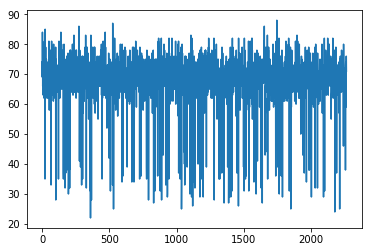

In [133]:
plt.plot(bppts)

(array([ 17.,  62.,  39.,   9.,   5.,  98., 762., 944., 294.,  32.]),
 array([22. , 28.6, 35.2, 41.8, 48.4, 55. , 61.6, 68.2, 74.8, 81.4, 88. ]),
 <a list of 10 Patch objects>)

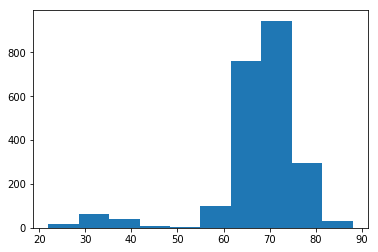

In [134]:
plt.hist(bppts)

In [19]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(2262, 18901, 1, 10139433)

In [135]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'of', '-', 'and', 'a', 'to', 'in', 'we']

In [136]:
' '.join(md.trn_ds[0].text[:150])

'<cat> csro <summ> detailed surface images of the moon and mars reveal hundreds of cave - like openings . these cave - like openings are theorized to be remnants of lava - tubes and their interior maybe in pristine conditions . these locations may have well preserved geological records of the moon and mars , including evidence of past water flow and habitability . exploration of these caves using wheeled rovers remains a daunting challenge . these caves are likely to have entrances with caved - in ceilings much like the lava - tubes of arizona and new mexico . thus , the entrances are nearly impossible to traverse even for experienced human hikers . our approach is to utilize the spherex robot , a 3 kg , 30 cm diameter robot with computer hardware and sensors of a smartphone attached to rocket thrusters . each spherex robot can hop'

### Train

In [137]:
em_sz = 200
nh = 500
nl = 3
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [138]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
    dropout=0.05, dropouth=0.1, dropouti=0.05, dropoute=0.02, wdrop=0.2)
# dropout=0.4, dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5
#                dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [139]:
warnings.filterwarnings("ignore",category=UserWarning)

In [140]:
learner.fit(3e-3, 1, wds=1e-6)

  0%|          | 4/2262 [00:13<2:01:57,  3.24s/it, loss=9.41]


KeyboardInterrupt



In [17]:
learner.save_encoder('adam2_enc')
learner.save('adam2')

In [ ]:
learner.fit(3e-3, 3, wds=1e-6, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       4.11236  3.99207]                                  
[ 1.       4.03207  3.89298]                                  
[ 2.       3.91653  3.81915]                                  
[ 3.       3.97808  3.8428 ]                                  
[ 4.       3.88482  3.76226]                                  
[ 5.       3.79955  3.70472]                                  
[ 6.       3.75721  3.69048]                                  



In [ ]:
learner.save_encoder('adam2_enc')

In [ ]:
learner.fit(3e-3, 10, wds=1e-6, cycle_len=5, cycle_save_name='adam3_10')

A Jupyter Widget

[ 0.       3.89388  3.76575]                                  
[ 1.       3.82548  3.71875]                                  
[ 2.       3.76471  3.66974]                                  
[ 3.       3.71713  3.63861]                                  
[ 4.       3.67534  3.62983]                                  
[ 5.       3.83938  3.71551]                                  
[ 6.       3.78093  3.68056]                                  
[ 7.       3.72828  3.63638]                                  
[ 8.       3.66743  3.60355]                                  
[ 9.       3.65793  3.59448]                                  
[ 10.        3.80545   3.68213]                               
[ 11.        3.75299   3.65219]                               
[ 12.        3.7057    3.61324]                               
[ 13.        3.63348   3.58048]                               
[ 14.        3.62304   3.57257]                               
[ 15.        3.78656   3.66324]                        

In [ ]:
learner.save_encoder('adam3_10_enc')

In [ ]:
learner.fit(3e-3, 8, wds=1e-6, cycle_len=10, cycle_save_name='adam3_5')

A Jupyter Widget

[ 0.       3.70587  3.61666]                                  
[ 1.       3.71738  3.61174]                                  
[ 2.       3.68606  3.59661]                                  
[ 3.       3.65407  3.5742 ]                                  
[ 4.       3.62901  3.55795]                                  
[ 5.       3.59921  3.53632]                                  
[ 6.       3.58401  3.52149]                                  
[ 7.       3.55126  3.50797]                                  
[ 8.       3.52965  3.50178]                                  
[ 9.       3.52336  3.49997]                                  
[ 10.        3.7109    3.60817]                               
[ 11.        3.69879   3.60047]                               
[ 12.        3.6735    3.58623]                               
[ 13.        3.64365   3.56568]                               
[ 14.        3.6099    3.54776]                               
[ 15.        3.58244   3.52829]                        

In [ ]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')

A Jupyter Widget

[ 0.       3.47841  3.4751 ]                                  
[ 1.       3.69717  3.57883]                                  
[ 2.       3.68267  3.57793]                                  
[ 3.       3.66797  3.57299]                                  
[ 4.       3.66805  3.56847]                                  
[ 5.       3.63489  3.56238]                                  
[ 6.       3.62479  3.54928]                                  
[ 7.       3.60663  3.53879]                                  
[ 8.       3.59124  3.53175]                                  
[ 9.       3.58617  3.52009]                                  
[ 10.        3.56924   3.51174]                               
[ 11.        3.5509    3.49974]                               
[ 12.        3.51595   3.49008]                               
[ 13.        3.50939   3.48222]                               
[ 14.        3.48886   3.47952]                               
[ 15.        3.4676    3.47311]                        

In [ ]:
learner.save_encoder('adam3_20_enc')

In [ ]:
learner.save('adam3_20')

### Test

In [32]:
learner.load_encoder('adam2_enc')
learner.load('adam2')

In [33]:
def proc_str(s): return TEXT.preprocess(TEXT.tokenize(s))
def num_str(s): return TEXT.numericalize([proc_str(s)])

In [34]:
m=learner.model.cpu()

In [35]:
s="""<CAT> cscv <SUMM> algorithms that"""

In [36]:
def sample_model(m, s, l=50):
    t = num_str(s)
    m[0].bs=1
    m.eval()
    m.reset()
    res,*_ = m(t)
    print('...', end='')

    for i in range(l):
        n=res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        word = TEXT.vocab.itos[n.data[0]]
        print(word, end=' ')
        if word=='<eos>': break
        res,*_ = m(n[0].unsqueeze(0).unsqueeze(0))

    m[0].bs=bs

In [37]:
sample_model(m,"<CAT> csni <SUMM> algorithms that")

...are able to capture the underlying dynamics of the network are a fundamental task in the field of machine learning . however , the performance of the proposed algorithms is not well understood . in this paper , we propose a novel approach to solve the problem of learning the 

In [38]:
sample_model(m,"<CAT> cscv <SUMM> algorithms that")

...are able to generate a single image in a single image are a challenging task . in this paper , we propose a novel approach to automatically generate 3d images from a single image . we propose a novel deep learning architecture that can effectively capture the object and pose 

In [39]:
sample_model(m,"<CAT> cscv <SUMM> algorithms. <TITLE> on ")

...the problem of image segmentation <eos> 

In [40]:
sample_model(m,"<CAT> csni <SUMM> algorithms. <TITLE> on ")

...the design of distributed systems in the presence of    high - latency systems <eos> 

In [41]:
sample_model(m,"<CAT> cscv <SUMM> algorithms. <TITLE> towards ")

...a large - scale dataset of large - scale data <eos> 

In [42]:
sample_model(m,"<CAT> csni <SUMM> algorithms. <TITLE> towards ")

...a new approach to the design of a distributed network <eos> 

### Sentiment

In [ ]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [ ]:
class ArxivDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for label in ['yes', 'no']:
            fnames = glob(os.path.join(path, label, '*.txt'));
            assert fnames, f"can't find 'yes.txt' or 'no.txt' under {path}/{label}"
            for fname in fnames:
                with open(fname, 'r') as f: text = f.readline()
                examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', **kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

In [ ]:
ARX_LABEL = data.Field(sequential=False)
splits = ArxivDataset.splits(TEXT, ARX_LABEL, PATH, train='trn', test='val')

In [ ]:
md2 = TextData.from_splits(PATH, splits, bs)

In [ ]:
#            dropout=0.3, dropouti=0.4, wdrop=0.3, dropoute=0.05, dropouth=0.2)

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_at_6(preds,targs):
    precision, recall, _ = precision_recall_curve(targs==2, preds[:,2])
    print(recall[precision>=0.6][0])
    return recall[precision>=0.6][0]

In [ ]:
# dropout=0.4, dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.65, wdrop=0.5, dropoute=0.1, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.clip=25.

In [ ]:
# this notebook has a mess of some things going under 'all/' others not, so a little hack here
!ln -sf ../all/models/adam3_20_enc.h5 {PATH}models/adam3_20_enc.h5
m3.load_encoder(f'adam3_20_enc')
lrs=np.array([1e-4,1e-3,1e-3,1e-2,3e-2])

In [ ]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

A Jupyter Widget

[ 0.       0.47654  0.44322  0.78525]                         



A Jupyter Widget

[ 0.       0.43033  0.40192  0.80087]                        



In [ ]:
m3.fit(lrs, 2, metrics=[accuracy], cycle_len=4, cycle_save_name='imdb2')

A Jupyter Widget

[ 0.       0.42236  0.39006  0.8194 ]                        
[ 1.       0.39477  0.37063  0.82086]                        
[ 2.       0.39389  0.37082  0.82449]                        
[ 3.       0.40728  0.36999  0.82195]                        
[ 4.       0.39308  0.3675   0.81977]                        
[ 5.       0.38662  0.36737  0.8234 ]                        
[ 6.       0.39259  0.36512  0.82486]                        
[ 7.       0.38047  0.36538  0.82522]                        



In [ ]:
prec_at_6(*m3.predict_with_targs())

0.659305993691


0.65930599369085174

In [ ]:
m3.fit(lrs, 4, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

A Jupyter Widget

[ 0.       0.38752  0.36351  0.82486]                        
[ 1.       0.38664  0.36123  0.82558]                        
[ 2.       0.3904   0.36098  0.82486]                        
[ 3.       0.37319  0.36144  0.82486]                        
[ 4.       0.38074  0.36334  0.82595]                        
[ 5.       0.36405  0.3594   0.82413]                        
[ 6.       0.38781  0.35914  0.82522]                        
[ 7.       0.37722  0.357    0.82631]                        



In [ ]:
prec_at_6(*m3.predict_with_targs())

0.695583596215


0.69558359621451105